### Trabajo Práctico N°1

In [122]:
## Importamos librerías
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import unidecode
import nltk, re, string, collections
from nltk.util import ngrams
import nltk, re, string, collections
from nltk.corpus import stopwords
sns.set(style="whitegrid")

In [61]:
##Leemos el csv
df = pd.read_csv('train.csv')

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [63]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [64]:
#Chequeo que no tengamos id repetidas
df.id.unique().size

7613

### Preprocesamiento de Keywors y Tweets

In [65]:
#Exploramos un poco los tweets
from IPython.core.display import HTML
tweets = df['text'].tail(10).values;
for tweet in tweets:
    display(HTML(tweet+"<hr>"))

In [66]:
df.keyword.fillna('other',inplace=True)
def limpieza_texto(df,name_col):
    #saco todos los links
    df.loc[:,name_col] = df[name_col].apply(lambda s: re.sub(r'https?://\S+', '', s))
    #saco todo lo que sea codigo HTML
    #df.loc[:,name_col] = df[name_col].apply(lambda s: re.sub('<.*?>', '', s))
    # saco todo lo que no sea alfanumerico
    df.loc[:,name_col] = df[name_col].apply(lambda s: re.sub(r'[^\w]', ' ', s))
    # lo paso a minuscula
    df.loc[:,name_col] = df[name_col].apply(lambda s: s.lower())
    # paso a unicode
    #df.loc[:,name_col] = df[name_col].apply(lambda s: unidecode.unidecode(s))  
    
    if name_col == 'keyword':
        # quito el numero 20 que aparece en la keyword
        df.loc[:,name_col] = df[name_col].apply(lambda s: re.sub('20', ' ', s))
    # saco los espacios en blanco de mas
    df.loc[:,name_col] = df[name_col].apply(lambda s: re.sub(' +',' ',s))
    return df

df = limpieza_texto(df,'text')
df = limpieza_texto(df,'keyword')

In [67]:
#Exploramos un poco los tweets
from IPython.core.display import HTML
tweets = df['text'].tail(10).values;
for tweet in tweets:
    display(HTML(tweet+"<hr>"))

#### Vamos a intentar completar las 61 Keywors nulas, a las que habíamos asignado 'other', fijándonos en los tweets y analizando si contienen una de las Keywords existentes.

In [70]:
mi_lista =["building burning","buildings burning", "buildings on fire","buldings","flames","bush fire","wildfire","hellfire","fire","truck fire","wild fires","bush fires","forest fires","arson","arsonist","burning","ablaze","blazing","blaze","burned"\
,"accident","airplane accident","bridge collapse","oil spill","collapse","electrocuted","electrocute","cliff fall","traped","collapsed","crashed","crushed","crush","wrecked","wreckage","wreck","collide","collided","collision","crash"\
,"apocalypse","armageddon","annihilated","annihilation","catastrophic","famine","ruin","catastrophe","razed","devastation","disaster","heat wave","pandemonium","destruction","desolation","desolate","destroyed","destroy","blight","demolition"\
,"terrorism","bioterror","bioterrorism","terrorist","threat","hijacker","hijacking","mass murder","mass murderer","massacre","massac","hostage","attack","hijack","attacked","detonate","suicide bomber","suicide bomb","blown up","suicide bombing","blew up", "blow up","bombing","bomb","bombed","exploded","explosion","explode"\
,"fatality","fatal","fatalities","casualty","casualties","deaths","death","drown","drowned", "drowning","drownet","tragedy","trauma","traumatised","blood","bleeding","dead","bloody","body bagging","body bag","body bags"\
,"thunderstorm","storm","twister","typhoon","hurricane","tornado","windstorm","rainstorm","sandstorm","hailstorm","hail","earthquake","flooding","mudslide","seismic","floods","inundated","inundation","landslide","lava","lightning","flood","thunder","tsunami","cyclone","deluge","snowstorm","avalanche","blizzard","whirlwind","volcano","drought"\
,"survivors","survivor","survive","survived","refugees","rescue","rescued","rescuers","wounded","deluged","derailed","flattened","harm"\
,"army","battle","military","police","weapons","weapon","war zone","hostages","mayhem","detonation","devastated","displaced","first responders","eyewitness","engulfed","injured","injuries","injury","obliterate","obliterated","obliteration"\
,"danger","damage","curfew","debris","trouble","demolish","meltdown","aftershock","nuclear reactor","structural failure","smoke","rubble","sinking","sinkhole","hazardous","hazard","fear","demolished","derail","derailet","derailment","epicentre","loud bang","rioting","riot"\
,"emergency","services emergency","plan emergency","ambulance","chemical emergency","evacuate","upheaval","sirens","wounds","siren","stretcher","evacuated","evacuation","outbreak","panic","screamed","screaming","screams","panicking"\
,"quarantine","quarantined"]

def encuentra_key(tweet): 
    for s in tweet:
        if s in mi_lista:
            return s
    return 'other'    

key_aux = df.loc[df['keyword']=='other',['keyword','text']]
key_aux['text'] = key_aux['text'].map(lambda x: x.lower())
key_aux['text'] = key_aux['text'].map(lambda x: x.split())
key_aux['keyword']=key_aux['text'].map(encuentra_key)

In [71]:
key_aux.keyword.values

array(['earthquake', 'fire', 'evacuation', 'evacuation', 'smoke', 'fire',
       'flood', 'fire', 'emergency', 'tornado', 'other', 'flooding',
       'flooding', 'flood', 'damage', 'other', 'other', 'other', 'other',
       'other', 'other', 'other', 'other', 'other', 'other', 'other',
       'other', 'other', 'other', 'other', 'other', 'bomb', 'explode',
       'police', 'seismic', 'sirens', 'attack', 'earthquake', 'typhoon',
       'other', 'other', 'other', 'exploded', 'flood', 'thunderstorm',
       'debris', 'collided', 'earthquake', 'evacuation', 'other', 'siren',
       'quarantine', 'fire', 'bomb', 'other', 'tornado', 'collapse',
       'other', 'volcano', 'police', 'razed'], dtype=object)

In [72]:
len(key_aux['keyword'])

61

In [73]:
df.loc[df['keyword']=='other','keyword'] = key_aux['keyword']

#### Se crea una Key Global, a modo de concepto, que trate de sectorizar a las keywords para luego analizarlas con un mejor detalle

In [75]:
mis_kw = df['keyword']

In [76]:
from flashtext import KeywordProcessor
keyword_processor = KeywordProcessor()
keyword_dict = {"Burning": ["building burning","buildings burning", "buildings on fire","buldings","flames","bush fire","wildfire","hellfire","fire","truck fire","wild fires","bush fires","forest fires","arson","arsonist","burning","ablaze","blazing","blaze","burned"]\
               ,"Accident": ["accident","airplane accident","bridge collapse","oil spill","collapse","electrocuted","electrocute","cliff fall","traped","trapped","collapsed","crashed","crushed","crush","wrecked","wreckage","wreck","collide","collided","collision","crash"]\
               ,"Apocalypse": ["apocalypse","armageddon","annihilated","annihilation","catastrophic","famine","ruin","catastrophe","razed","devastation","disaster","heat wave","pandemonium","destruction","desolation","desolate","destroyed","destroy","blight","demolition"]\
               ,"Attack": ["terrorism","bioterror","bioterrorism","terrorist","threat","hijacker","hijacking","mass murder","mass murderer","massacre","massac","hostage","attack","hijack","attacked","detonate","suicide bomber","suicide bomb","blown up","suicide bombing","blew up", "blow up","bombing","bomb","bombed","exploded","explosion","explode"]\
               ,"Fatality": ["fatality","fatal","fatalities","casualty","casualties","deaths","death","drown","drowned", "drowning","drownet","tragedy","trauma","traumatised","blood","bleeding","dead","bloody","body bagging","body bag","body bags","sunk"]\
               ,"Natural Phenomenon": ["thunderstorm","storm","twister","typhoon","hurricane","tornado","windstorm","rainstorm","sandstorm","hailstorm","hail","earthquake","flooding","mudslide","seismic","floods","inundated","inundation","landslide","lava","lightning","flood","thunder","tsunami","cyclone","deluge","snowstorm","avalanche","blizzard","whirlwind","volcano","drought"]\
               ,"Survivor": ["survivors","survivor","survive","survived","refugees","rescue","rescued","rescuers","wounded","deluged","derailed","flattened","harm"]\
               ,"Security": ["army","battle","military","police","weapons","weapon","war zone","hostages","mayhem","detonation","devastated","displaced","first responders","eyewitness","engulfed","injured","injuries","injury","obliterate","obliterated","obliteration"]\
               ,"Danger": ["danger","damage","curfew","debris","trouble","demolish","meltdown","aftershock","nuclear reactor","structural failure","smoke","rubble","sinking","sinkhole","hazardous","hazard","fear","demolished","derail","derailet","derailment","epicentre","loud bang","rioting","riot"]\
               ,"Emergency": ["emergency","services emergency","plan emergency","ambulance","chemical emergency","evacuate","upheaval","sirens","wounds","siren","stretcher","evacuated","evacuation","outbreak","panic","screamed","screaming","screams","panicking","quarantine","quarantined"]\
               ,"Otro": ["other"]}
key_depuradas=[]
keyword_processor.add_keywords_from_dict(keyword_dict)
for w in mis_kw:
       if len(keyword_processor.extract_keywords(w))==1:
            key_depuradas.append(keyword_processor.extract_keywords(w)[0])
       
       else: 
            key_depuradas.append(w)

In [77]:
len(key_depuradas)

7613

In [78]:
df['key_global'] = key_depuradas

In [79]:
df.key_global.unique()

array(['Natural Phenomenon', 'Burning', 'Emergency', 'Danger', 'Otro',
       'Accident', 'Apocalypse', 'Security', 'Attack', 'Fatality',
       'Survivor'], dtype=object)

In [80]:
df.sample(10)

,id,keyword,location,text,target,key_global
200,281,ambulance,VISIT MY YOUTUBE CHANNEL.,happening now hatzolah ems ambulance respondin...,0,Emergency
4854,6913,mass murderer,NaN,white people i know you worry tirelessly about...,1,Attack
6359,9089,structural failure,"Chicago, IL",ntsb virgin galactic crash caused by structura...,1,Danger
814,1182,blizzard,Guelph Ontario Canada,new print available on waiting too long by pam...,0,Natural Phenomenon
2471,3542,derailment,"Minneapolis,MN,US",train derailment in patna no news of any casua...,1,Danger
6288,8983,storm,Desert Storm?? |BCHS|,happy birthday lesley_mariiee i miss you so mu...,0,Natural Phenomenon
1426,2058,casualties,Mostly Yuin.,whimsy as it pertains to mass casualties alway...,0,Fatality
6282,8973,storm,#BossNation!,finna storm fuck my back boutta start hurting ...,0,Natural Phenomenon
2658,3819,detonate,Colorado,bldrcosheriff says 2nd grenade found is young...,1,Attack
97,139,accident,"Hagerstown, MD",breaking there was a deadly motorcycle car ac...,1,Accident


In [82]:
df['Veracidad']= '' 
df.loc[df['target']== 1,'Veracidad']= 'Real'
df.loc[df['target']== 0,'Veracidad']= 'Falso'

'Diagrama de flujo de KeyWors Globales en relacion a la veracidad de los Tweets'

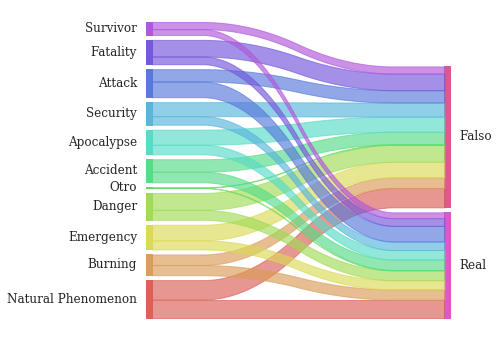

In [84]:
from pySankey import sankey
display('Diagrama de flujo de KeyWors Globales en relacion a la veracidad de los Tweets')
sankey.sankey(df['key_global'],df['Veracidad'],aspect=20, fontsize=12)

### Análisis de KeyWord

> * Un primer análisis para tener una idea de cuáles son las palabras más frecuentes de KeyWord y key_global utilizamos Wordcloud.

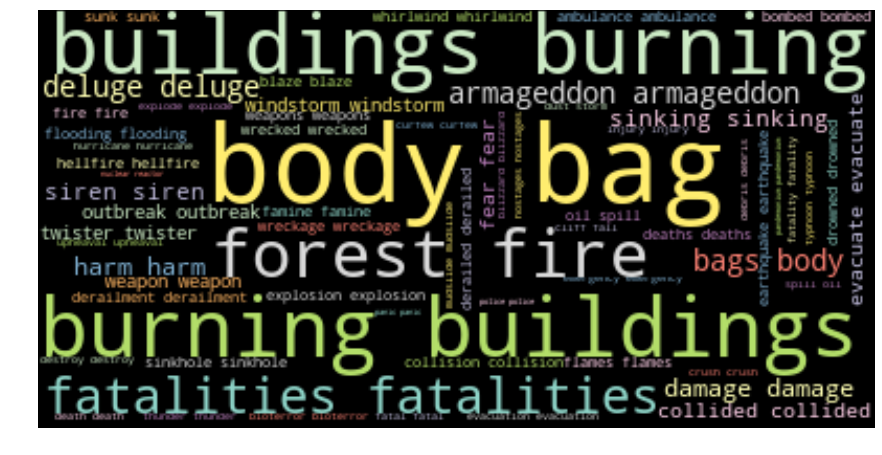

In [87]:
from wordcloud import WordCloud, ImageColorGenerator
text = " ".join(str(each) for each in df['keyword'])
wordcloud = WordCloud(max_words=200,colormap='Set3', background_color="black").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.show()

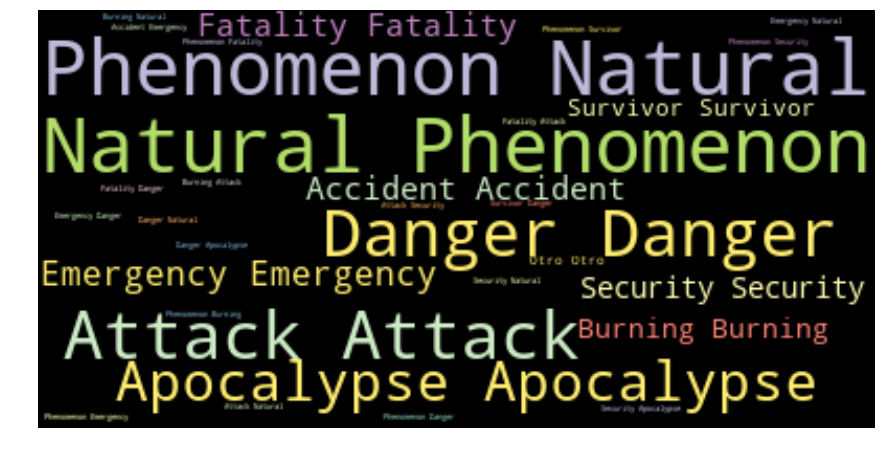

In [88]:
from wordcloud import WordCloud, ImageColorGenerator
text = " ".join(str(each) for each in df['key_global'])
wordcloud = WordCloud(max_words=200,colormap='Set3', background_color="black").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.show()

> ####  Top 10 KeyWord casos donde no hay accidente Real 

Text(0, 0.5, 'KeyWords')

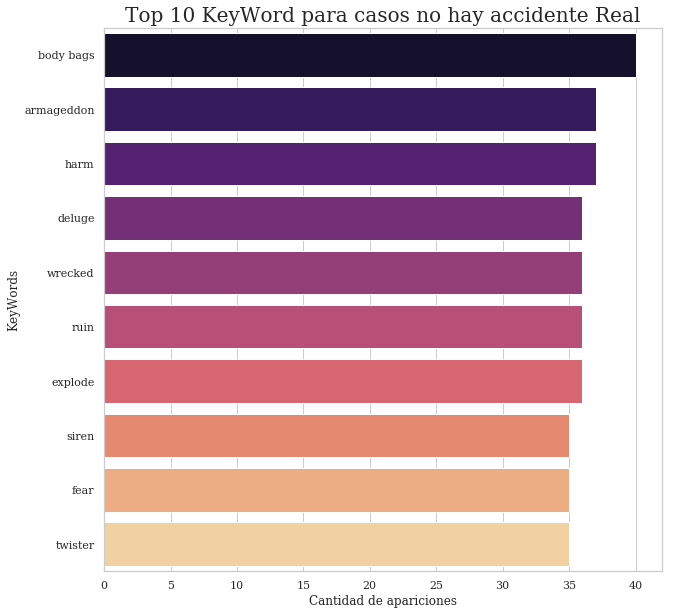

In [89]:
top_KeyWord = df.loc[df['target']== 0,'keyword'].value_counts().head(10)
plt.subplots(figsize=(10,10))
grafico_top_key=sns.barplot(x=top_KeyWord.values,y=top_KeyWord.index,orient='h',palette="magma")
grafico_top_key.set_title("Top 10 KeyWord para casos no hay accidente Real",fontsize=20)
grafico_top_key.set_xlabel("Cantidad de apariciones",fontsize=12)
grafico_top_key.set_ylabel("KeyWords",fontsize=12)
#plt.savefig('grafico_2')

> #### Top 10 KeyWord para casos reales de accidentes

Text(0, 0.5, 'KeyWords')

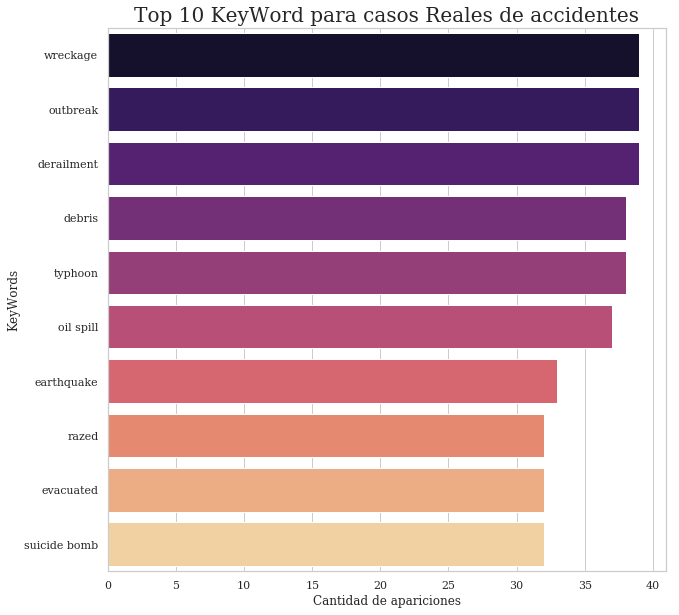

In [90]:
top_KeyWord = df.loc[df['target']== 1,'keyword'].value_counts().head(10)
plt.subplots(figsize=(10,10))
grafico_top_key=sns.barplot(x=top_KeyWord.values,y=top_KeyWord.index,orient='h',palette="magma")
grafico_top_key.set_title("Top 10 KeyWord para casos Reales de accidentes",fontsize=20)
grafico_top_key.set_xlabel("Cantidad de apariciones",fontsize=12)
grafico_top_key.set_ylabel("KeyWords",fontsize=12)
#plt.savefig('grafico_3')

### Análisis de Twetts

In [91]:
df['longitud'] = df.apply(lambda row: len(row['text']),axis=1)

In [92]:
df['veces'] = 1

In [95]:
mi_map=pd.crosstab(df['key_global'], df['Veracidad'],values=df.veces,aggfunc=np.sum)

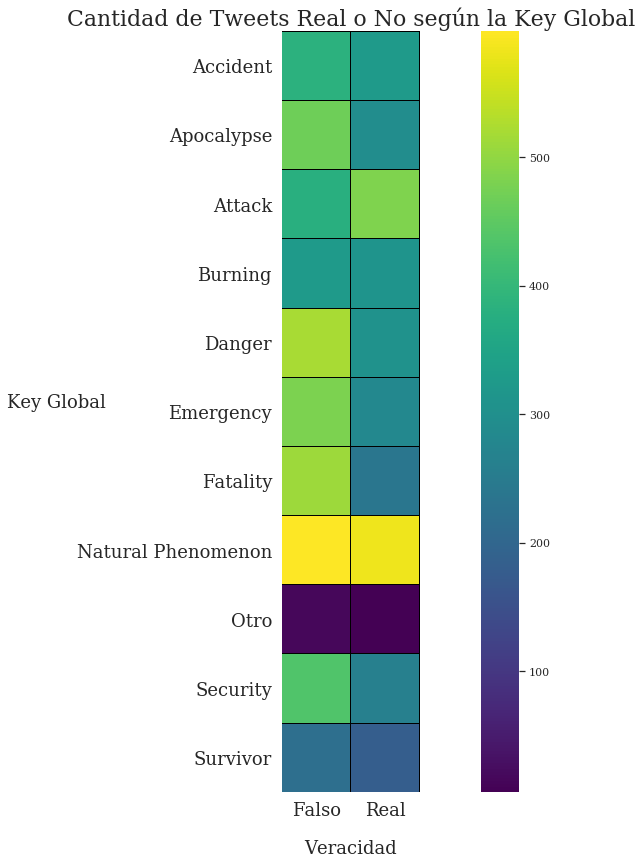

In [97]:
fig, ax = plt.subplots(figsize=(22,14))

g = sns.heatmap(mi_map, cmap="viridis", ax=ax, linewidths=0.005, linecolor='black', square=True)
g.set_title("Cantidad de Tweets Real o No según la Key Global", fontsize=22)
g.set_xlabel("Veracidad", fontsize=18, labelpad=20)
g.set_ylabel("Key Global", fontsize=18, labelpad=20, rotation=0)
g.set_xticklabels(g.get_xticklabels(), fontsize=18)
g.set_yticklabels(g.get_yticklabels(), fontsize=18, rotation=0)

g.title.set_position([0.5, 1.05])
plt.show()

In [118]:
real = df.loc[df['target']== 1,['key_global','longitud']]
falso = df.loc[df['target']== 0,['key_global','longitud']]

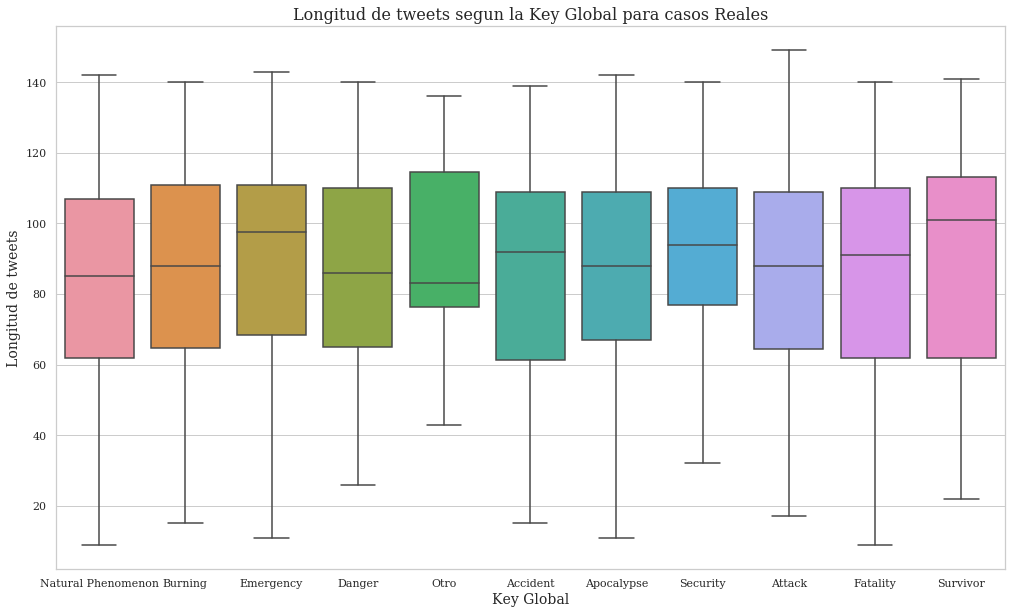

In [119]:
fig, ax = plt.subplots(figsize=(17,10))
ax = sns.boxplot(x='key_global', y='longitud', data=real)
ax.set_xlabel('Key Global',fontsize=14);
ax.set_ylabel('Longitud de tweets',fontsize=14);
ax.set_title("Longitud de tweets segun la Key Global para casos Reales", fontsize=16);

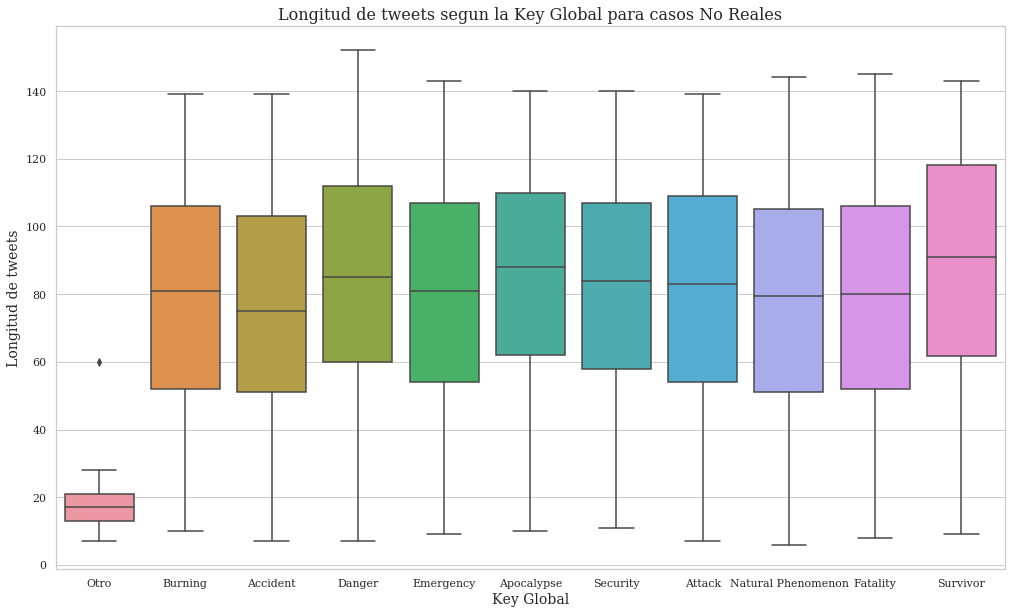

In [120]:
fig, ax = plt.subplots(figsize=(17,10))
ax = sns.boxplot(x='key_global', y='longitud', data=falso)
ax.set_xlabel('Key Global',fontsize=14);
ax.set_ylabel('Longitud de tweets',fontsize=14);
ax.set_title("Longitud de tweets segun la Key Global para casos No Reales", fontsize=16);

### N-Gramas

In [123]:
print(set(stopwords.words('English')))

{'at', 'both', "mightn't", 'of', 'am', 'will', 'other', 'themselves', 'did', 'very', 'no', 'he', 'myself', "didn't", 'hadn', 'there', 'further', 'didn', 'had', "hasn't", "doesn't", 'are', 'such', 'each', 'doing', "won't", "aren't", 'these', 'above', 'out', 'ain', 'because', 'shouldn', 'theirs', 'all', 'your', 'any', "shouldn't", 'y', 'them', 'for', 'himself', 'doesn', 'hasn', 'his', 'wasn', 'is', 'only', 'yours', 'do', 'about', 'from', "should've", 'me', 'below', 'up', 'ma', "couldn't", 'were', 'mightn', 'when', 'the', 'isn', 'should', 'this', 'that', 'now', 'she', "needn't", 'having', 'd', 'who', 'mustn', 'does', 'haven', "hadn't", 'what', 'as', "that'll", "you'd", 'not', 'its', 'off', 'over', 'more', "you're", 'here', 'm', 'their', 'through', "haven't", 'have', 'shan', 'was', 'by', 'between', 'weren', 'if', "don't", 'once', 'hers', 'to', 'my', 'with', 'her', 'which', 're', 'you', 'o', 'yourselves', 'and', 's', 'aren', 'before', 'll', 'during', 'nor', 'just', 'don', 'itself', 'why', '

In [125]:
df.longitud.sum()

640081

In [169]:
mis_stopwors = list(stopwords.words('English'))
filtrado_real = []
for tweet in df.loc[df['target']== 1,'text']:
    for palabra in tweet.split():
        if palabra not in mis_stopwors:
            filtrado_real.append(palabra)

In [175]:
filtrado_no_real = []
for tweet in df.loc[df['target']== 0,'text']:
    for palabra in tweet.split():
        if palabra not in mis_stopwors:
            filtrado_no_real.append(palabra)

In [176]:
def encontrar_ngramas(palabras, n):
    lista = []
    ngramas = ngrams(palabras, n)
    for k in ngramas:
            lista.append(k)
    
    final = [(lambda x: ' '.join(x))(x) for x in lista]
    return final

### Unigrams

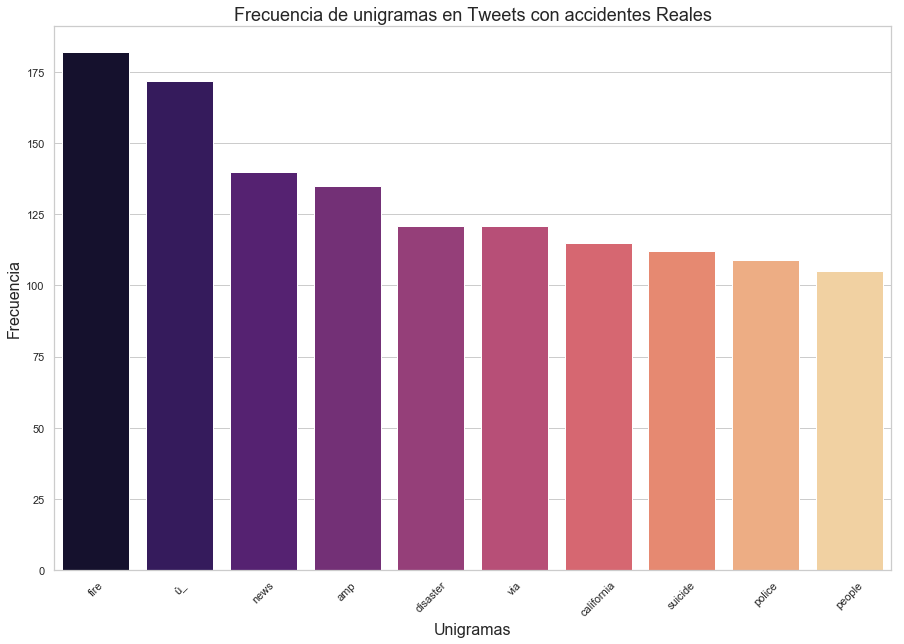

In [177]:
unigramas = encontrar_ngramas(filtrado_real, 1)
serie = pd.Series(x for x in unigramas).value_counts().head(10)
plt.figure(figsize=[15,10])
g = sns.barplot(x=serie.index, y=serie.values, palette='magma')
g.set_title('Frecuencia de unigramas en Tweets con accidentes Reales', fontsize=18)
g.set_xlabel('Unigramas', fontsize=16)
g.set_ylabel('Frecuencia', fontsize=16)
plt.xticks(rotation=45)
plt.show()

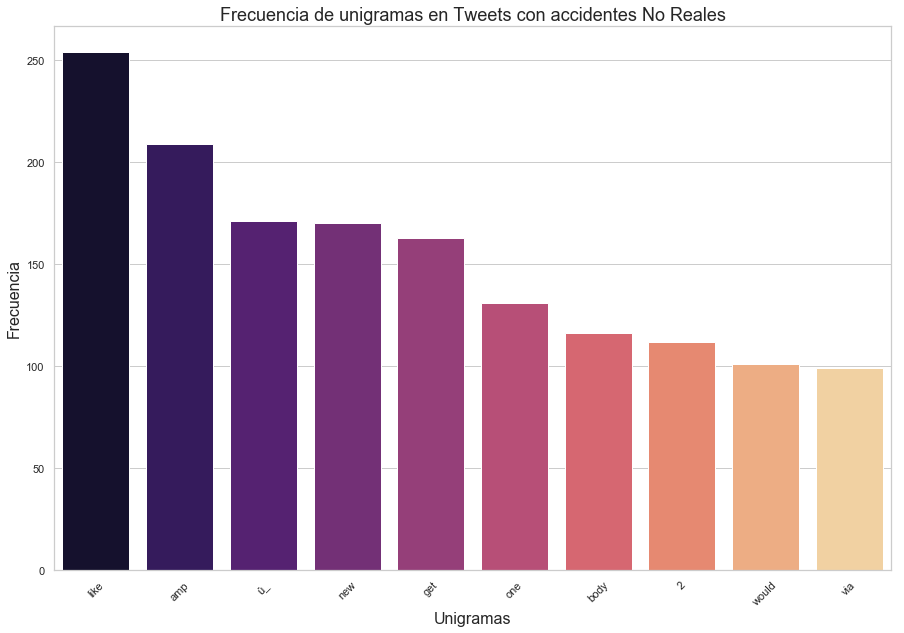

In [178]:
unigramas = encontrar_ngramas(filtrado_no_real, 1)
serie = pd.Series(x for x in unigramas).value_counts().head(10)
plt.figure(figsize=[15,10])
g = sns.barplot(x=serie.index, y=serie.values, palette='magma')
g.set_title('Frecuencia de unigramas en Tweets con accidentes No Reales', fontsize=18)
g.set_xlabel('Unigramas', fontsize=16)
g.set_ylabel('Frecuencia', fontsize=16)
plt.xticks(rotation=45)
plt.show()

### Bigramas

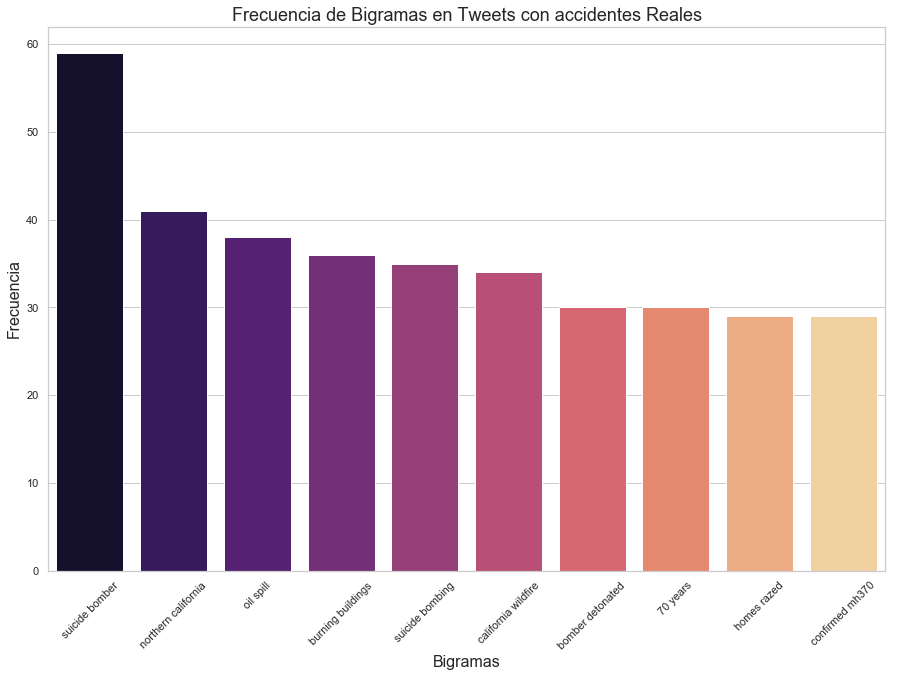

In [180]:
bi = encontrar_ngramas(filtrado_real, 2)
serie = pd.Series(x for x in bi).value_counts().head(10)
plt.figure(figsize=[15,10])
g = sns.barplot(x=serie.index, y=serie.values, palette='magma')
g.set_title('Frecuencia de Bigramas en Tweets con accidentes Reales', fontsize=18)
g.set_xlabel('Bigramas', fontsize=16)
g.set_ylabel('Frecuencia', fontsize=16)
plt.xticks(rotation=45)
plt.show()

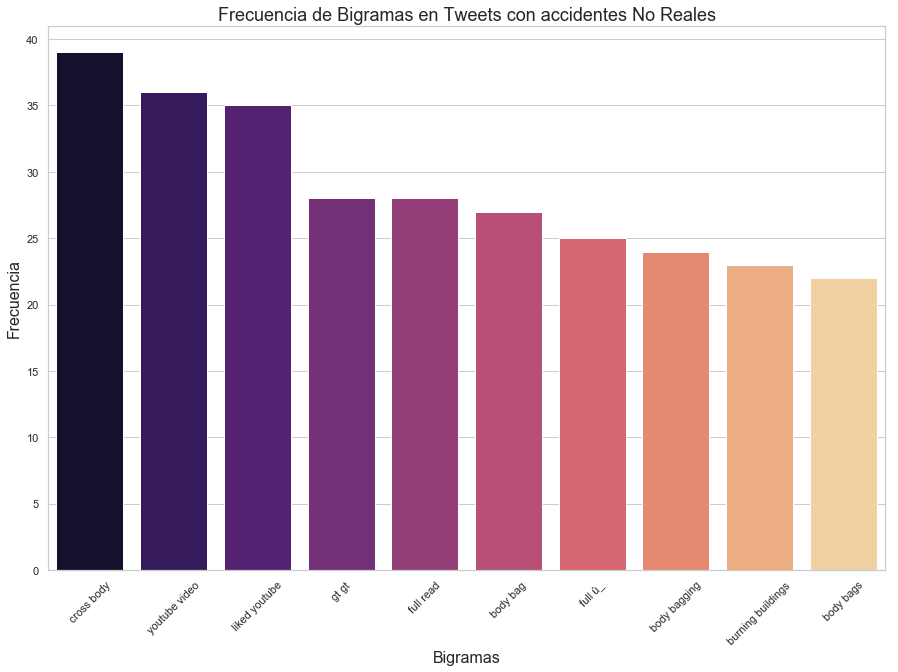

In [181]:
bi = encontrar_ngramas(filtrado_no_real, 2)
serie = pd.Series(x for x in bi).value_counts().head(10)
plt.figure(figsize=[15,10])
g = sns.barplot(x=serie.index, y=serie.values, palette='magma')
g.set_title('Frecuencia de Bigramas en Tweets con accidentes No Reales', fontsize=18)
g.set_xlabel('Bigramas', fontsize=16)
g.set_ylabel('Frecuencia', fontsize=16)
plt.xticks(rotation=45)
plt.show()

### Trigramas

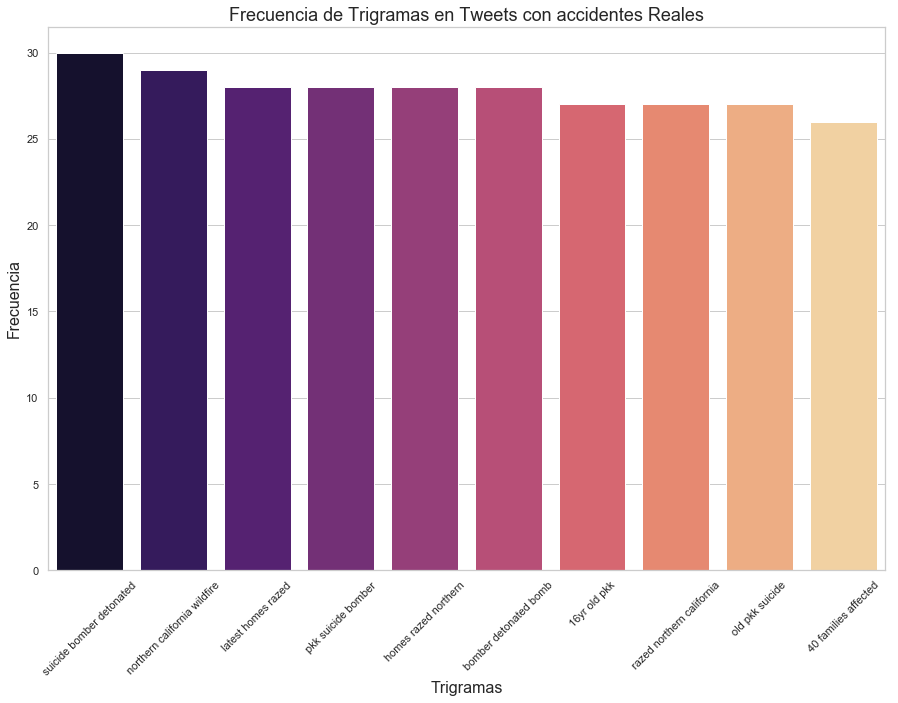

In [182]:
tri = encontrar_ngramas(filtrado_real, 3)
serie = pd.Series(x for x in tri).value_counts().head(10)
plt.figure(figsize=[15,10])
g = sns.barplot(x=serie.index, y=serie.values, palette='magma')
g.set_title('Frecuencia de Trigramas en Tweets con accidentes Reales', fontsize=18)
g.set_xlabel('Trigramas', fontsize=16)
g.set_ylabel('Frecuencia', fontsize=16)
plt.xticks(rotation=45)
plt.show()

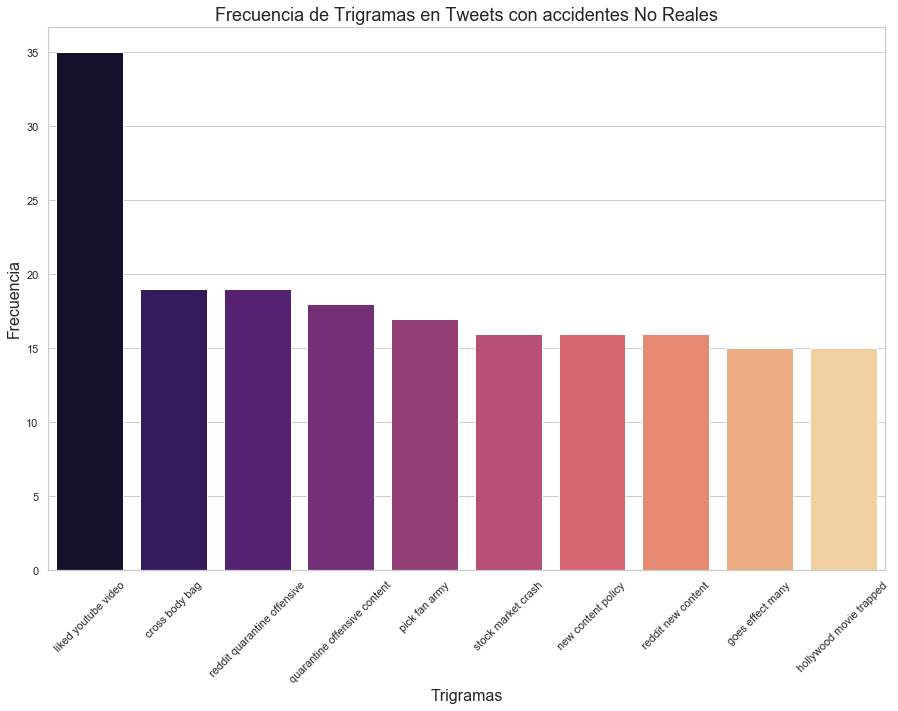

In [183]:
tri = encontrar_ngramas(filtrado_no_real, 3)
serie = pd.Series(x for x in tri).value_counts().head(10)
plt.figure(figsize=[15,10])
g = sns.barplot(x=serie.index, y=serie.values, palette='magma')
g.set_title('Frecuencia de Trigramas en Tweets con accidentes No Reales', fontsize=18)
g.set_xlabel('Trigramas', fontsize=16)
g.set_ylabel('Frecuencia', fontsize=16)
plt.xticks(rotation=45)
plt.show()